In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import os
import matplotlib.pyplot as plt

In [2]:
tf.random.set_seed(23)

In [6]:
# Cargar y Preprocesar el Dataset
dataset_dir = "../datasets_insectos"
image_size = (224, 224)  # MobileNetV3 espera imágenes de 224x224
batch_size = 16

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, "train"),
    labels="inferred",
    label_mode="int",
    image_size=image_size,
    interpolation="bicubic",
    batch_size=batch_size,
    shuffle=True,
    follow_links=False,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, "val"),
    labels="inferred",
    label_mode="int",
    image_size=image_size,
    interpolation="bicubic",
    batch_size=batch_size,
    shuffle=False,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, "test"),
    labels="inferred",
    label_mode="int",
    image_size=image_size,
    interpolation="bicubic",
    batch_size=batch_size,
    shuffle=False,
)

# Obtener los nombres de las clases (ordenados por el directorio)
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Clases detectadas: {class_names}")
print(f"Número de clases: {num_classes}")


Found 641 files belonging to 5 classes.
Found 78 files belonging to 5 classes.
Found 85 files belonging to 5 classes.
Clases detectadas: ['arana-mona', 'bachaco', 'bachaco-culon', 'libelula', 'saltamontes']
Número de clases: 5


In [7]:
# Configurar el aumento de datos (Data Augmentation)
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
        # Puedes añadir más capas de aumento de datos aquí
    ],
    name="data_augmentation",
)

In [8]:
# Aplicar aumento solo al conjunto de entrenamiento
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [9]:
# Optimizar el rendimiento de la carga de datos
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
# Cargar MobileNetV3
base_model = tf.keras.applications.MobileNetV3Large(
    input_shape=image_size + (3,),
    include_top=False,
    weights='imagenet',
)

base_model.trainable = False  # No actualizar capas inferiores en las primeras épocas

In [11]:
inputs = keras.Input(shape=image_size + (3,))
x = inputs

# Construir modelo de fine-tuning
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)  # Capa de dropout para regularización
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         4,805 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,001,157 (11.45 MB)

 Trainable params: 4,805 (18.77 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [12]:
# Definir el Early Stopping
early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
    verbose=1,
)

In [13]:
epochs_initial = 10
print(f"\nEntrenando las capas superiores por {epochs_initial} épocas...")
history_initial = model.fit(
    train_ds,
    epochs=epochs_initial,
    validation_data=val_ds,
    callbacks=[early_stopping_callback],
)


Entrenando las capas superiores por 10 épocas...
Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 26s 360ms/step - accuracy: 0.4736 - loss: 1.4457 - val_accuracy: 0.8974 - val_loss: 0.3618
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 205ms/step - accuracy: 0.8926 - loss: 0.3553 - val_accuracy: 0.9359 - val_loss: 0.2496
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 236ms/step - accuracy: 0.9441 - loss: 0.2094 - val_accuracy: 0.9487 - val_loss: 0.2088
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 246ms/step - accuracy: 0.9633 - loss: 0.1511 - val_accuracy: 0.9487 - val_loss: 0.2039
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.9627 - loss: 0.1279 - val_accuracy: 0.9487 - val_loss: 0.2024
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 191ms/step - accuracy: 0.9720 - loss: 0.1020 - val_accuracy: 0.9615 - val_loss: 0.1881
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 191ms/step - accuracy: 0.9845 - loss: 0.0885 - val_accuracy: 0.9487 - val_loss: 0.1876
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 192ms/step

In [14]:
base_model.trainable = True

# Congelar capas de Batch Normalization (BN)
# Es una práctica común dejar las capas de Batch Normalization congeladas durante el fine-tuning,
# ya que sus estadísticas pueden volverse inestables con tamaños de batch pequeños.
for layer in base_model.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

# Recompilar el modelo con un learning rate más bajo
model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=1e-5
    ),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         4,805 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,001,157 (11.45 MB)

 Trainable params: 2,952,357 (11.26 MB)

 Non-trainable params: 48,800 (190.62 KB)

In [15]:
epochs_fine_tune = 10  # Más épocas para el fine-tuning profundo
total_epochs = epochs_initial + epochs_fine_tune

print(
    f"\nContinuando el entrenamiento (fine-tuning profundo) por {epochs_fine_tune} épocas..."
)
history_fine_tune = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history_initial.epoch[-1] + 1,
    validation_data=val_ds,
    callbacks=[early_stopping_callback],
)


Continuando el entrenamiento (fine-tuning profundo) por 10 épocas...
Epoch 11/20


41/41 ━━━━━━━━━━━━━━━━━━━━ 37s 549ms/step - accuracy: 0.9831 - loss: 0.0589 - val_accuracy: 0.9615 - val_loss: 0.1847
Epoch 12/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 518ms/step - accuracy: 0.9937 - loss: 0.0304 - val_accuracy: 0.9615 - val_loss: 0.1880
Epoch 13/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 504ms/step - accuracy: 0.9993 - loss: 0.0240 - val_accuracy: 0.9615 - val_loss: 0.1774
Epoch 14/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 500ms/step - accuracy: 0.9996 - loss: 0.0201 - val_accuracy: 0.9487 - val_loss: 0.1779
Epoch 15/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 484ms/step - accuracy: 1.0000 - loss: 0.0139 - val_accuracy: 0.9615 - val_loss: 0.1788
Epoch 16/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 551ms/step - accuracy: 1.0000 - loss: 0.0098 - val_accuracy: 0.9615 - val_loss: 0.1718
Epoch 17/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 25s 604ms/step - accuracy: 1.0000 - loss: 0.0142 - val_accuracy: 0.9487 - val_loss: 0.1662
Epoch 18/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 559ms/step - accuracy: 0.9993 - loss: 0.0070 - val_accuracy

In [16]:
# --- 8. Evaluar el Modelo ---
loss, accuracy = model.evaluate(test_ds)
print(f"\nPrecisión en el conjunto de prueba: {accuracy * 100:.2f}%")


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.9704 - loss: 0.0570

Precisión en el conjunto de prueba: 97.65%


In [17]:
# --- 9. Guardar el Modelo ---
model.save("mobilenet_v3_insectos_fine_tuned_model.h5")

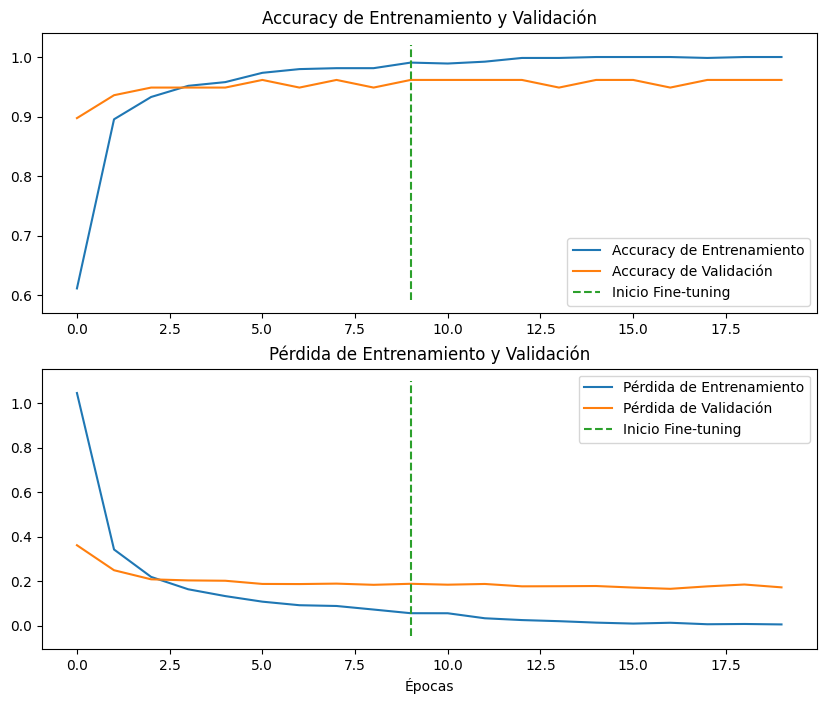

In [18]:
# --- 10. Visualizar el Historial de Entrenamiento ---
def plot_history(history_initial, history_fine_tune):
    acc = history_initial.history["accuracy"] + history_fine_tune.history["accuracy"]
    val_acc = (
        history_initial.history["val_accuracy"]
        + history_fine_tune.history["val_accuracy"]
    )
    loss = history_initial.history["loss"] + history_fine_tune.history["loss"]
    val_loss = (
        history_initial.history["val_loss"] + history_fine_tune.history["val_loss"]
    )

    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label="Accuracy de Entrenamiento")
    plt.plot(val_acc, label="Accuracy de Validación")
    plt.plot(
        [epochs_initial - 1, epochs_initial - 1],
        plt.ylim(),
        label="Inicio Fine-tuning",
        linestyle="--",
    )
    plt.legend(loc="lower right")
    plt.title("Accuracy de Entrenamiento y Validación")

    plt.subplot(2, 1, 2)
    plt.plot(loss, label="Pérdida de Entrenamiento")
    plt.plot(val_loss, label="Pérdida de Validación")
    plt.plot(
        [epochs_initial - 1, epochs_initial - 1],
        plt.ylim(),
        label="Inicio Fine-tuning",
        linestyle="--",
    )
    plt.legend(loc="upper right")
    plt.title("Pérdida de Entrenamiento y Validación")
    plt.xlabel("Épocas")
    plt.show()


plot_history(history_initial, history_fine_tune)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


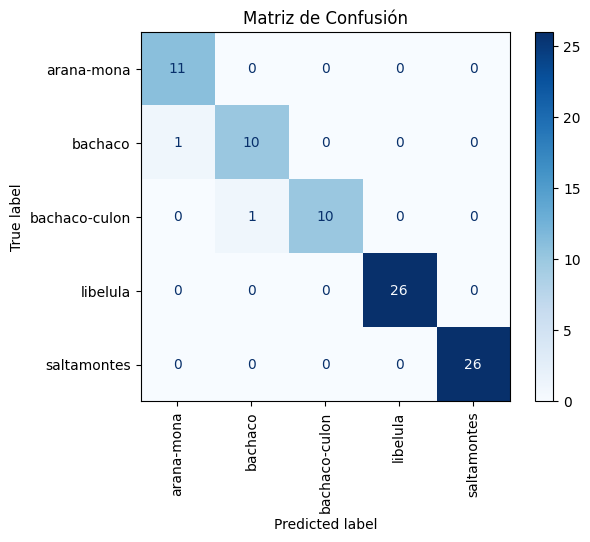

In [19]:
# Ver matriz de confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def plot_confusion_matrix(model, test_ds):
    y_true = []
    y_pred = []

    for images, labels in test_ds:
        predictions = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(predictions.argmax(axis=1))

    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Matriz de Confusión")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.xticks(rotation=90)
    plt.show()

plot_confusion_matrix(model, test_ds)